### Модель 1. Константное предсказание

Решение задачи начнём с самого простого классификатора, который выдаёт на каждом объекте константное предсказание — самый часто встречающийся класс.

In [ ]:
from sklearn.datasets 
import load_breast_cancer 
the_data = load_breast_cancer()    

# 0 — «доброкачественный» 
# 1 — «злокачественный» 
relabeled_target = 1 - the_data["target"] 

from sklearn.model_selection import train_test_split 
X = the_data["data"] 
y = relabeled_target 
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0) 

from sklearn.dummy import DummyClassifier 
dc_mf = DummyClassifier(strategy="most_frequent") 
dc_mf.fit(X_train, y_train) 

from sklearn.metrics import confusion_matrix 
y_true = y_test y_pred = dc_mf.predict(X_test) 
dc_mf_tn, dc_mf_fp, dc_mf_fn, dc_mf_tp = confusion_matrix(y_true, y_pred, labels = [0, 1]).ravel() 

	
Прогнозируемый класс +

Прогнозируемый класс -

Истинный класс +

TP = 0

FN = 53

Истинный класс -

FP = 0

TN = 90

Обучающие данные таковы, что наш dummy-классификатор все объекты записывает в отрицательный класс, то есть признаёт все опухоли доброкачественными. Такой наивный подход позволяет нам получить минимальный штраф за FP (действительно, нельзя ошибиться в предсказании, если положительный класс вообще не предсказывается), но и максимальный штраф за FN (в эту группу попадут все злокачественные опухоли).

### Модель 2. Случайный лес.

Настало время воспользоваться всем арсеналом моделей машинного обучения, и начнём мы со случайного леса.

In [ ]:
from sklearn.ensemble import RandomForestClassifier 
rfc = RandomForestClassifier()       
rfc.fit(X_train, y_train)       
y_true = y_test       
y_pred = rfc.predict(X_test)       
rfc_tn, rfc_fp, rfc_fn, rfc_tp = confusion_matrix(y_true, y_pred, labels = [0, 1]).ravel()

| Прогнозируемый класс + | Прогнозируемый класс - |
|-------------------------|-------------------------|
| Истинный класс +        | TP = 52                | FN = 1                 |
| Истинный класс -        | FP = 4                 | TN = 86                |

Можно сказать, что этот классификатор чему-то научился, так как главная диагональ матрицы стала содержать все объекты из отложенной выборки, за исключением 4 + 1 = 5 объектов (сравните с 0 + 53 объектами dummy-классификатора, все охули объявляющего доброкачественными).

Отметим, что вычисляя долю недиагональных элементов, мы приходим к метрике *error rate*, о которой мы говорили в самом начале:

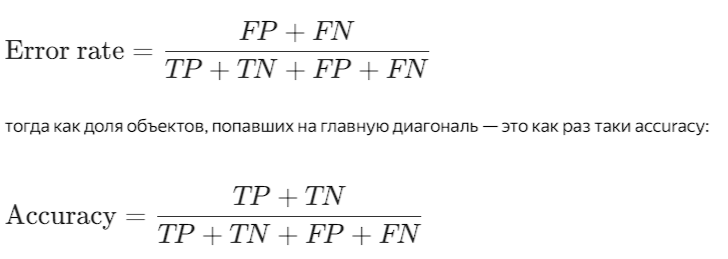

### Модель 3. Метод опорных векторов.

Давайте построим еще один классификатор на основе линейного метода опорных векторов.

In [ ]:
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler 
ss = StandardScaler() ss.fit(X_train) 
scaled_linsvc = LinearSVC(C=0.01,random_state=42) 
scaled_linsvc.fit(ss.transform(X_train), y_train) 
y_true = y_test 
y_pred = scaled_linsvc.predict(ss.transform(X_test)) 
tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels = [0, 1]).ravel() 

Сравним результаты

Легко заметить, что каждая из двух моделей лучше классификатора-пустышки, однако давайте попробуем сравнить их между собой. С точки зрения error rate модели практически одинаковы: 5/143 для леса против 4/143 для SVM.

Посмотрим на структуру ошибок чуть более внимательно: лес — (FP = 4, FN = 1), SVM — (FP = 1, FN = 3).

Что же всё-таки важнее уменьшить: FP или FN? Вернёмся к задаче:

FP — доля доброкачественных опухолей, которым ошибочно присваивается метка злокачественной;
FN — доля злокачественных опухолей, которые классификатор пропускает.
В такой постановке становится понятно, что при сравнении выиграет модель с меньшим FN (то есть лес в нашем примере), ведь каждая не обнаруженная опухоль может стоить человеческой жизни.

Рассмотрим теперь другую задачу: по данным о погоде предсказать, будет ли успешным запуск спутника. FN в такой постановке — это ошибочное предсказание неуспеха, то есть не более, чем упущенный шанс (если вас, конечно не уволят за срыв сроков). С FP всё серьёзней: если вы предскажете удачный запуск спутника, а на деле он потерпит крушение из-за погодных условий, то ваши потери будут в разы существеннее.